In [19]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [20]:
two_composite_filtered = pd.read_csv("../Curated_data/cluster_0_data.csv", low_memory=False)

In [21]:
variable = 'Density_gcm3'
covariates = ['Sc_ppm']
#covariates = ['Sulph1_Code', 'Sulph1_Pct']


#Select columns of interest
selected_columns = ["Name", 'X', 'Y', 'Z', variable] + covariates
two_composite_1covariates = two_composite_filtered[selected_columns]

#Drop NA's and filter for the chosen hole
two_composite_1covariates = two_composite_1covariates.dropna(subset=[variable] + covariates)


In [22]:
len(two_composite_1covariates['Density_gcm3'])

2426

In [23]:

encoded_data = two_composite_1covariates.copy()

threshold = 10

for column in two_composite_1covariates.columns:
    if two_composite_1covariates[column].dtype == 'object':
        unique_values = two_composite_1covariates[column].nunique()
        
        # Check if the number of unique values is within the threshold
        if unique_values <= threshold:
            # Perform one-hot encoding for columns with unique values within the threshold
            encoded_columns = pd.get_dummies(encoded_data[column], prefix=column)
            encoded_columns = encoded_columns.astype(int)  # Convert to integers (0 or 1)
            encoded_data = pd.concat([encoded_data, encoded_columns], axis=1)
            encoded_data = encoded_data.drop(columns=[column])



In [24]:
# Identify the encoded columns based on the common pattern
encoded_columns = [col for col in encoded_data.columns if '_Code_' in col]

# List to store the total columns
total_columns = []

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column and sum them
    encoded_data[total_column] = (
        encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    )

In [25]:
# List to store the total columns
total_columns = []

# Initialize a dictionary to accumulate totals for each category
category_totals = {}

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    if total_column not in total_columns:
        total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column
    total_values = encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    
    # Accumulate the totals for each category
    if total_column in category_totals:
        category_totals[total_column] += total_values
    else:
        category_totals[total_column] = total_values

# Add accumulated totals to the DataFrame
for total_column, total_values in category_totals.items():
    encoded_data[total_column] = total_values


In [26]:
#Activate this cell to use dummies for the sulphides
total_columns = encoded_data[['Sc_ppm']].columns.tolist()


In [27]:
deposit_data = encoded_data[["Name","X", "Y", "Z", "Density_gcm3"] + total_columns]
covariates = total_columns[:1]

- Iteration 0, MSE: 0.261


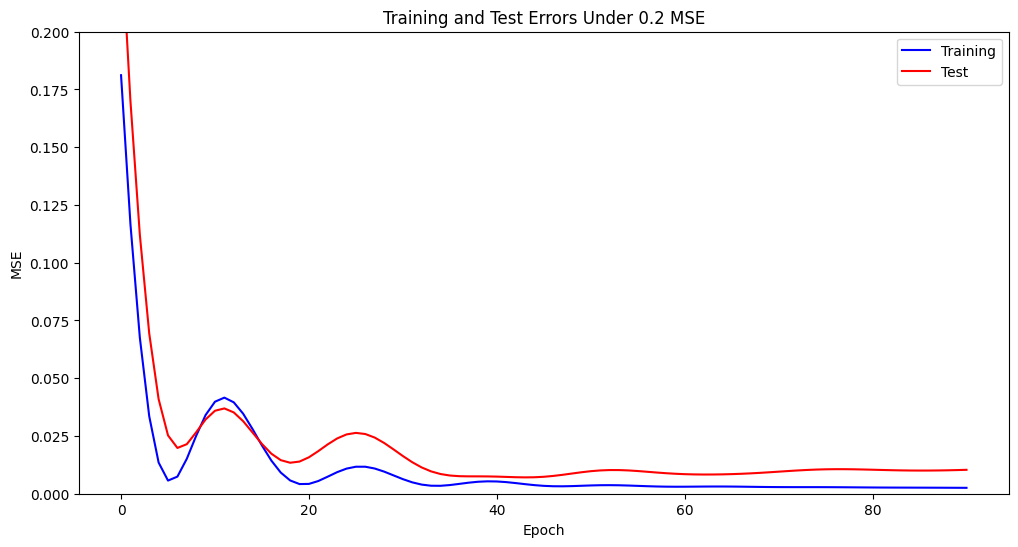

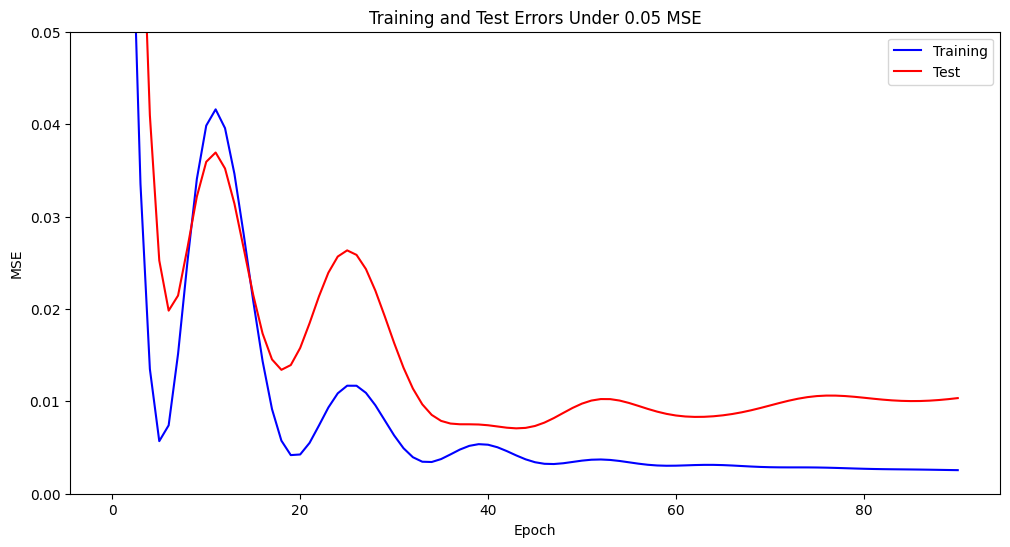

In [28]:
np.random.seed(42)
torch.manual_seed(42)

# Create a MinMaxScaler instance
scaler = MinMaxScaler()


# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']   # Add all columns you want to normalize

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)


deposit_data.loc[:, [variable]+covariates] = scaler.fit_transform(deposit_data.loc[:,[variable]+covariates])


deposit_data=deposit_data.sort_values(by='Z')

x = deposit_data[['X','Y', 'Z'] + covariates].values #[:,np.newaxis] makes the second dimension explicit
y = deposit_data[[variable]].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(deposit_data),3+len(covariates))
x = x[:,[i for i in range(3+len(covariates))]]





x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the unique 'Name' values
unique_names = deposit_data['Name'].unique()

# Initialize empty lists to store training and testing data
x_train = []
y_train = []
x_test = []
y_test = []

# Iterate through unique 'Name' values and assign each hole's data to either train or test
for name in unique_names:
    # Select data for the current hole
    hole_data = deposit_data[deposit_data['Name'] == name]
    x_hole = hole_data[['X', 'Y', 'Z'] + covariates].values
    y_hole = hole_data['Density_gcm3'].values

    # Assign the hole's data to either train or test
    if np.random.rand() < 0.2:  # You can adjust the ratio, e.g., 0.2 for a 80/20 split
        x_test.extend(x_hole)
        y_test.extend(y_hole)
    else:
        x_train.extend(x_hole)
        y_train.extend(y_hole)

# Convert the lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)



inp_features = 3 + len(covariates)
model = nn.Sequential(
    nn.Linear(in_features=inp_features, out_features=500),
    nn.ReLU(),
    nn.Linear(in_features=500, out_features=1)
)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(91):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 1000 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.3f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.2)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.05)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.05 MSE')
plt.show()







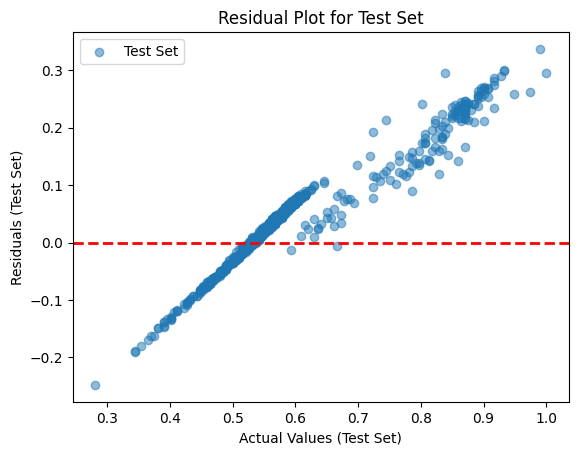

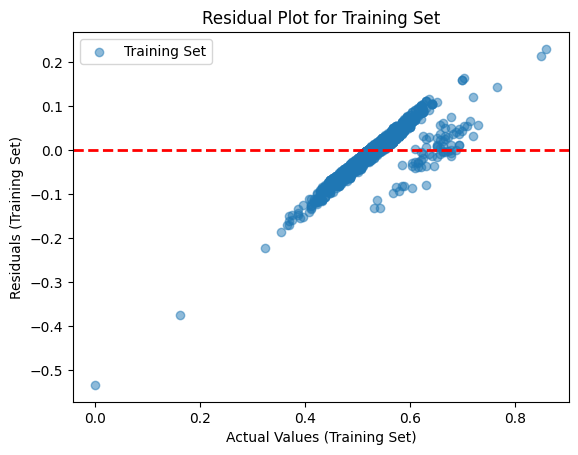

Metrics for Test set:
  MSE: 0.0103
  RMSE: 0.1017
  MAE: 0.0735
  R^2: 0.3665

Metrics for Training set:
  MSE: 0.0026
  RMSE: 0.0505
  MAE: 0.0379
  R^2: 0.1991



In [29]:
import matplotlib.pyplot as plt

# Generate predictions for the test set
test_predictions = model(x_test)

# Convert torch tensors to NumPy arrays
y_test_np = y_test.numpy()
test_predictions_np = test_predictions.detach().numpy()


# Calculate residuals for the test set
test_residuals = y_test_np - test_predictions_np

# Plot residuals for the test set
plt.scatter(y_test_np, test_residuals, alpha=0.5, label='Test Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Residuals (Test Set)')
plt.title('Residual Plot for Test Set')
plt.legend()
plt.show()

# Generate predictions for the training set
train_predictions = model(x_train)

# Convert torch tensors to NumPy arrays
y_train_np = y_train.numpy()
train_predictions_np = train_predictions.detach().numpy()



# Calculate residuals for the training set
train_residuals = y_train_np - train_predictions_np

# Plot residuals for the training set
plt.scatter(y_train_np, train_residuals, alpha=0.5, label='Training Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Residuals (Training Set)')
plt.title('Residual Plot for Training Set')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Print metrics for the test set
print_metrics(y_test_np, test_predictions_np, "Test")

# Print metrics for the training set
print_metrics(y_train_np, train_predictions_np, "Training")


## Cross validation

Fold 1:
Training MSE: 0.00, Test MSE: 0.00
Fold 2:
Training MSE: 0.00, Test MSE: 0.00
Fold 3:
Training MSE: 0.00, Test MSE: 0.00
Fold 4:
Training MSE: 0.00, Test MSE: 0.00
Fold 5:
Training MSE: 0.00, Test MSE: 0.00
Cross-validation results:
Mean Training MSE = 0.00, Std. Dev. Training MSE = 0.00
Mean Test MSE = 0.00, Std. Dev. Test MSE = 0.00


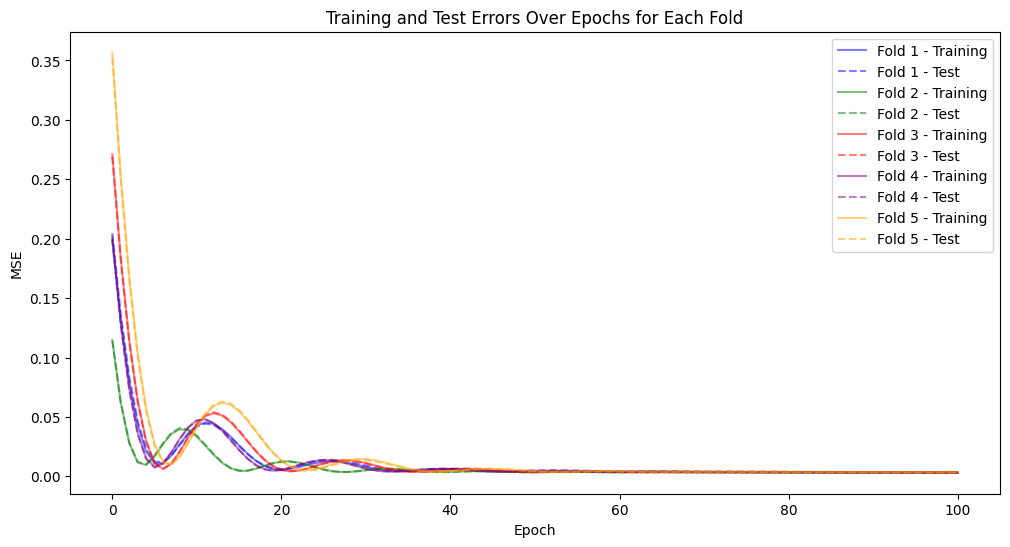

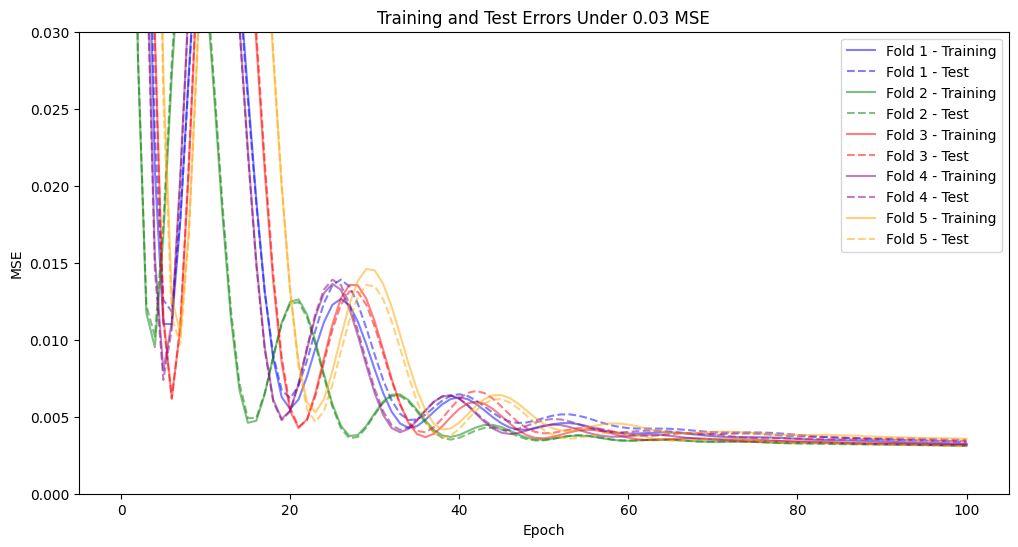

In [30]:
np.random.seed(42)
torch.manual_seed(42)

# Create a MinMaxScaler instance
scaler = MinMaxScaler()


# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']   # Add all columns you want to normalize

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)


deposit_data.loc[:, [variable]+covariates] = scaler.fit_transform(deposit_data.loc[:,[variable]+covariates])


deposit_data=deposit_data.sort_values(by='Z')

x = deposit_data[['X','Y', 'Z'] + covariates].values #[:,np.newaxis] makes the second dimension explicit
y = deposit_data[[variable]].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(deposit_data),3+len(covariates))
x = x[:,[i for i in range(3+len(covariates))]]





x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the unique 'Name' values
unique_names = deposit_data['Name'].unique()

# Initialize empty lists to store training and testing data
x_train = []
y_train = []
x_test = []
y_test = []

# Iterate through unique 'Name' values and assign each hole's data to either train or test
for name in unique_names:
    # Select data for the current hole
    hole_data = deposit_data[deposit_data['Name'] == name]
    x_hole = hole_data[['X', 'Y', 'Z'] + covariates].values
    y_hole = hole_data['Density_gcm3'].values

    # Assign the hole's data to either train or test
    if np.random.rand() < 0.2:  # You can adjust the ratio, e.g., 0.2 for a 80/20 split
        x_test.extend(x_hole)
        y_test.extend(y_hole)
    else:
        x_train.extend(x_hole)
        y_train.extend(y_hole)

# Convert the lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)





n_splits = 5  # You can choose the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)








# Define a list of colors for each fold
colors = ['blue', 'green', 'red', 'purple', 'orange']

mse_train_values = []  # To store training MSE for each fold
mse_test_values = []   # To store test MSE for each fold

for i, (train_indices, val_indices) in enumerate(kf.split(x)):
    x_train_fold = x[train_indices]
    y_train_fold = y[train_indices]
    x_val_fold = x[val_indices]
    y_val_fold = y[val_indices]

    inp_features = 3+len(covariates)
    model = nn.Sequential(
        nn.Linear(in_features=inp_features, out_features=500),
        nn.ReLU(),
        nn.Linear(in_features=500, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    for step in range(101):
        pre = model(x_train_fold)
        mse = mse_loss(pre, y_train_fold.reshape(-1, 1))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Evaluate the model on the training set
        pre_train = model(x_train_fold)
        mse_train = mse_loss(pre_train, y_train_fold.reshape(-1, 1))
        train_losses.append(mse_train.item())

        # Evaluate the model on the validation set
        pre_val = model(x_val_fold)
        mse_val = mse_loss(pre_val, y_val_fold.reshape(-1, 1))
        test_losses.append(mse_val.item())

    mse_train_values.append(train_losses)
    mse_test_values.append(test_losses)

    print(f'Fold {i + 1}:')
    print(f'Training MSE: {mse_train.item():.2f}, Test MSE: {mse_val.item():.2f}')

    

# Calculate the mean and standard deviation of training and test MSE values across folds
mean_train_mse = np.mean(mse_train_values, axis=0)
std_train_mse = np.std(mse_train_values, axis=0)
mean_test_mse = np.mean(mse_test_values, axis=0)
std_test_mse = np.std(mse_test_values, axis=0)

print(f'Cross-validation results:')
print(f'Mean Training MSE = {mean_train_mse[-1]:.2f}, Std. Dev. Training MSE = {std_train_mse[-1]:.2f}')
print(f'Mean Test MSE = {mean_test_mse[-1]:.2f}, Std. Dev. Test MSE = {std_test_mse[-1]:.2f}')



# Create a plot of training and test errors for each fold in the same plot
plt.figure(figsize=(12, 6))
for i in range(n_splits):
    plt.plot(range(len(train_losses)), mse_train_values[i], linestyle='-', label=f'Fold {i + 1} - Training', color=colors[i], alpha=0.5)
    plt.plot(range(len(test_losses)), mse_test_values[i], linestyle='--', label=f'Fold {i + 1} - Test', color=colors[i], alpha=0.5)

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Training and Test Errors Over Epochs for Each Fold')

# Create a plot showing only values lower than 0.03 on the y-axis
plt.figure(figsize=(12, 6))
for i in range(n_splits):
    plt.plot(range(len(train_losses)), mse_train_values[i], linestyle='-', label=f'Fold {i + 1} - Training', color=colors[i], alpha=0.5)
    plt.plot(range(len(test_losses)), mse_test_values[i], linestyle='--', label=f'Fold {i + 1} - Test', color=colors[i], alpha=0.5)

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.03)  # Set the y-axis limit to filter values under 0.03
plt.legend()
plt.title('Training and Test Errors Under 0.03 MSE')
plt.show()


In [31]:
deposit_data

,Name,X,Y,Z,Density_gcm3,Sc_ppm
66799,R679,0.311978,0.741697,0.000000,0.447917,0.031244
66798,R679,0.311874,0.741724,0.000894,0.453125,0.023927
66797,R679,0.311766,0.741751,0.001793,0.447917,0.017006
66796,R679,0.311658,0.741778,0.002692,0.447917,0.026893
66795,R679,0.311554,0.741806,0.003587,0.447917,0.026498
...,...,...,...,...,...,...
76609,R819,0.267229,0.808093,0.425658,0.619792,0.030453
80526,KV294,0.260828,0.126274,0.425915,0.989583,0.729088
76761,R820,0.131772,0.808211,0.426082,0.375000,0.020566
69517,R695,0.123094,0.853262,0.426168,0.421875,0.106783


In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

# Extract unique 'Name' values
unique_names = deposit_data['Name'].unique()

# Create an array to store metrics for each fold
test_mse_list = []
test_rmse_list = []
test_mae_list = []
test_r2_list = []

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(unique_names)):
    train_names, test_names = unique_names[train_index], unique_names[test_index]

    # Filter data based on selected train and test names
    train_data = deposit_data[deposit_data['Name'].isin(train_names)]
    test_data = deposit_data[deposit_data['Name'].isin(test_names)]

    x_train = train_data[['X', 'Y', 'Z'] + covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test = test_data[['X', 'Y', 'Z'] + covariates].values
    y_test = test_data['Density_gcm3'].values


    # Define your neural network
    model = nn.Sequential(
        nn.Linear(in_features=4, out_features=500),
        nn.ReLU(),
        nn.Linear(in_features=500, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(81):
        pre = model(torch.tensor(x_train, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_rmse_list.append(np.sqrt(test_mse_list[-1]))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average RMSE: {np.mean(test_rmse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R^2: {np.mean(test_r2_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0079
  RMSE: 0.0887
  MAE: 0.0643
  R^2: -0.3773


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0030
  RMSE: 0.0552
  MAE: 0.0379
  R^2: -0.2660


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0057
  RMSE: 0.0754
  MAE: 0.0594
  R^2: -1.0958


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0035
  RMSE: 0.0595
  MAE: 0.0482
  R^2: -0.5990


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0038
  RMSE: 0.0619
  MAE: 0.0486
  R^2: -1.5899


Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0037
  RMSE: 0.0608
  MAE: 0.0517
  R^2: 0.0322


Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0023
  RMSE: 0.0476
  MAE: 0.0418
  R^2: -0.4555


Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0495
  RMSE: 0.2225
  MAE: 0.2046
  R^2: -5.0621


Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0033
  RMSE: 0.0577
  MAE: 0.0470
  R^2: -0.1614


Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0034
  RMSE: 0.0579
  MAE: 0.0

## Train and test samples completely random

In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

# Assuming deposit_data, covariates, and other necessary variables are defined

# Create an array to store metrics for each fold
test_mse_list = []
test_rmse_list = []
test_mae_list = []
test_r2_list = []

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train = train_data[['X', 'Y', 'Z'] + covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test = test_data[['X', 'Y', 'Z'] + covariates].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network
    model = nn.Sequential(
        nn.Linear(in_features=4, out_features=500),
        nn.ReLU(),
        nn.Linear(in_features=500, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(81):
        pre = model(torch.tensor(x_train, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_rmse_list.append(np.sqrt(test_mse_list[-1]))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average RMSE: {np.mean(test_rmse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R^2: {np.mean(test_r2_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0042
  RMSE: 0.0650
  MAE: 0.0497
  R^2: 0.4845


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0031
  RMSE: 0.0554
  MAE: 0.0430
  R^2: 0.6150


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0037
  RMSE: 0.0606
  MAE: 0.0480
  R^2: 0.5966


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0032
  RMSE: 0.0562
  MAE: 0.0426
  R^2: 0.5647


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0034
  RMSE: 0.0586
  MAE: 0.0451
  R^2: 0.5042


Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0039
  RMSE: 0.0622
  MAE: 0.0427
  R^2: 0.5424


Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0039
  RMSE: 0.0625
  MAE: 0.0505
  R^2: 0.5085


Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0038
  RMSE: 0.0618
  MAE: 0.0496
  R^2: 0.4912


Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0035
  RMSE: 0.0588
  MAE: 0.0442
  R^2: 0.4749


Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0032
  RMSE: 0.0569
  MAE: 0.0462
  R^

In [42]:
# Pool the values from predictions_hole and y_hole

x_grid = np.linspace(x[:, 0].min(), x[:, 0].max(), 50)
y_grid = np.linspace(x[:, 1].min(), x[:, 1].max(), 50)
z_grid = np.linspace(x[:, 2].min(), x[:, 2].max(), 50)
xyz_grid = np.array(np.meshgrid(x_grid, y_grid, z_grid)).T.reshape(-1, 3)




fig = go.Figure(data=[
    go.Scatter3d(
    x=xyz_grid[:,0],
    y=xyz_grid[:,1],
    z=xyz_grid[:,2],
    mode='markers',
    marker=dict(
        size=4,

        colorscale='Hot',  # Adjust the color scale

        opacity=0.7,
    ),
    name='Test set'
)])

# Add a scatter plot for test data points
fig.add_trace(go.Scatter3d(
    x=x.data.numpy()[:, 0],
    y=x.data.numpy()[:, 1],
    z=x.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y.data.numpy().ravel(),
        colorscale='Hot',  # Adjust the color scale

        opacity=0.7,

    ),
    name='Test set'
))